# Debugging Overestimate in Long-time Concentration Gradient by Numerical Adaptation of Epstein-Plesset Model

I noticed on February 20, 2021, that, with the correction of the finite-difference formulas using the resource from Chris Balzer, "Deriving Nonuniform Differentiation Algorithms," the concentration gradient at the surface of the bubble, $\left.\frac{dc}{dr}\right|_{r=R_{bub}}$, is overestimated by the numerical model at later times after an egregious underestimation due to the finite size of the mesh elements unable to resolve the infinite gradient at the beginning.

This notebook explores possible causes for this late-time overestimation.

**February 21, 2021**: found bug in `bubble.adaptive_time_step()` where the method took the result from taking two time steps but passed back the length of one time step for use in the diffusion problem, resulting in mismatched conditions between bubble and bulk.

### Import Libraries

In [1]:
# adds custom libraries to path
import sys
sys.path.append('../libs/')

# imports standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# imports custom libraries
import polyco2
import diffn
import flow
import bubble
import bubbleflow
import analytics as an
import finitediff as fd

# plotting
import plot.diffn as pltd
import plot.bubble as pltb
import plot.genl as pltg

# CONVERSIONS
from conversions import *
# CONSTANTS
from constants import *

from importlib import reload

### Declare System Parameters

In [22]:
# flow parameters for experiments in 20200905_80bar folder
# viscosity of inner and outer streams [Pa.s]
eta_i = 0.25 # rough estimate of VORANOL 360 + CO2 dissolved so should be lower
eta_o = 4.815
# length of observation capillary [m]
L = 10E-2
# outer stream radius [m]
R_o = 150E-6
Q_o = 200 # outer stream flow rate, input to ISCO 260 D [uL/min]
# inner stream flow rate [uL/min]
Q_i = 100
# saturation pressure [Pa]
p_s = 80E5
# distance down capillary at which measurements were taken in videos of effect of flow rate on 20200905_80bar [m]
d = 0.096

# bubble growth model parameters
dt = 1E-12 # [s]
R_nuc = 5E-6 # [m] arbitrary bubble size for comparing models

# grid parameters
R_max = 100E-6 # outer radius [m]

# diffusion model parameters 
dc_c_s_frac = 0.01 # step size in concentration for estimating dD/dc as a fraction of saturation concentration

# load data (interfacial tension, solubility, and diffusivity) for polyols? we don't have data for VORANOL 360...use 1k3f
polyol_data_file = '1k3f_22c.csv'

# equation of state data
eos_co2_file = 'eos_co2_22-0C.csv'

# plot parameters
t_fs = 18
ax_fs = 16
tk_fs = 14
l_fs = 12

### Calculating Flow Parameters

In [23]:
# computes inner stream radius [m] and velocity [m/s]
dp, R_i, v = flow.get_dp_R_i_v_max(eta_i, eta_o, L, Q_i*uLmin_2_m3s, Q_o*uLmin_2_m3s, R_o, SI=True)
# inlet pressure [Pa]
p_in = P_ATM - dp
# nucleation time [s]
t_nuc = d/v

### Compute Epstein-Plesset Result as a Benchmark

In [24]:
reload(bubble)
# collects relevant parameters
eps_params = (dt, p_s, R_nuc, L, p_in, v, polyol_data_file, eos_co2_file)

# Epstein-Plesset solution for comparison
t_eps, m, D, p_eps, p_bub, if_tension, c_s, c_bulk, R_eps, rho_co2 = bubble.grow(t_nuc, *eps_params)
props_list_eps = (R_eps, m, p_eps, p_bub, rho_co2, if_tension)

# uses 2nd-order Taylor stencil to compute concentration gradient at the surface of the bubble
dcdr_eps = bubble.calc_dcdr_eps(c_bulk, c_s, R_eps, D, np.asarray(t_eps) - t_nuc)

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:233: RuntimeWarning: divide by zero encountered in true_divide
  """


### Compute Numerical Model Result and Compare Concentration Gradient at Bubble's Surface

In [25]:
reload(fd)
reload(an)
# list of N values to consider
N_list = [50, 100, 200, 400]
dt_max_list = [0.5*(R_max/N)**2/D for N in N_list] # dt < half of diffusive time scale [s]

t_eps, dcdr_eps, t_num_list, dcdr_num_list = an.calc_dcdr_eps_fix_D(N_list, R_max, t_nuc, eps_params, 
                                                                    dt_max_list=dt_max_list)

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Discrepancy in Concentration Gradient vs. N')

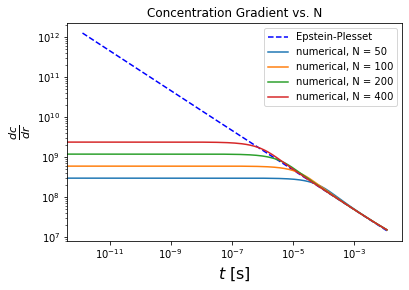

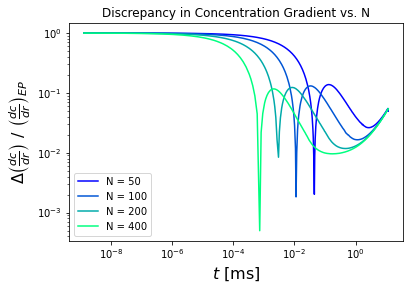

In [26]:
# plots results
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.asarray(t_eps) - t_eps[0], dcdr_eps, 'b--', label='Epstein-Plesset')

for N, dcdr_num, t_num in zip(N_list, dcdr_num_list, t_num_list):
    ax.plot(np.asarray(t_num) - t_num[0], dcdr_num, label='numerical, N = {0:d}'.format(N))


ax.set_xlabel(r'$t$ [s]', fontsize=16)
ax.set_ylabel(r'$\frac{dc}{dr}$', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()
ax.set_title('Concentration Gradient vs. N')

# plot difference
dcdr_diff_list = []
label_list = []
reload(pltd)
for N, dcdr_num, t_num in zip(N_list, dcdr_num_list, t_num_list):
    # computes fractional differencies in concentration gradient
    dcdr_diff_list += [np.abs(np.interp(t_eps, t_num, dcdr_num) - np.asarray(dcdr_eps)) / np.asarray(dcdr_eps)]
    label_list += ['N = {0:d}'.format(N)]
    
# plots discrepancies
ax = pltd.diff(t_eps, dcdr_diff_list, label_list)
ax.set_title('Discrepancy in Concentration Gradient vs. N')

We see that the error in the concentration gradient is enormous at the beginning because the finite grid cannot resolve the initially sharp gradient. Shortly after the concentration gradient in the analytical, Epstein-Plesset model decreases to the level that the numerical model's grid can resolve. However, the numerical model "falls behind" the analytical model, reaching the equivalent surface concentration gradient at a consistent fractional time delay afterwards. 

Interestingly, the spatial resolution of the grid does not reduce the error in the gradient at long times, despite improving the accuracy at early times. **This** is the error I will seek to debug in this notebook.

So, **why is the concentration gradient a consistent overestimate at later times?** My guess would be that, due to the gross underestimate in the concentration gradient at early times, the diffusive flux of CO2 into the bubble is slower initially, resulting in a shorter diffusion layer and a steeper concentration gradient.

Could it be...
- The diffusion volume is large enough that it feels the effect of the finite size of the domain, resulting in some flux from the boundary of CO2 that increases the flux into the bubble?
    *No, increasing the domain size to 200 $\mu$m had no noticeable effect on the error in the bubble radius*
- The decrease in pressure in the bubble results in greater flux than in Epstein-Plesset (does my E-P model account for this?)?
    *No, the Epstein-Plesset model accounts for pressure change*
- The difference in Tolman length? The Epstein-Plesset model was still using 0 nm, whereas the numerical model was using 5 nm.
    *No, the errors are just as high when I change the Tolman length to 5 nm for the Epstein-Plesset model.*

**THE CAUSE WAS A BUG IN THE `bubble.adaptive_time_step()` FUNCTION THAT PASSED ON A DIFFERENT TIME STEP THAN WAS TAKEN--RESOLVED.**

I explore some of these questions more deeply in the cells below.

#### Solution 1: Increase domain size

In [9]:
# double domain size from 100 um to 200 um
R_max = 200E-6 # [m]

# list of N values to consider
N_list = [50, 100, 200, 400]
dt_max_list = [0.5*(R_max/N)**2/D for N in N_list] # dt < half of diffusive time scale [s]

t_eps, dcdr_eps, t_num_list, dcdr_num_list = an.calc_dcdr_eps_fix_D(N_list, R_max, t_nuc, eps_params, 
                                                                    dt_max_list=dt_max_list)

C:\Users\andyl\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\bubble-growth\bubble.py:233: RuntimeWarning: divide by zero encountered in true_divide
  1/np.sqrt(np.pi*D*(np.asarray(t))))


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Discrepancy in Concentration Gradient vs. N for 200 um grid')

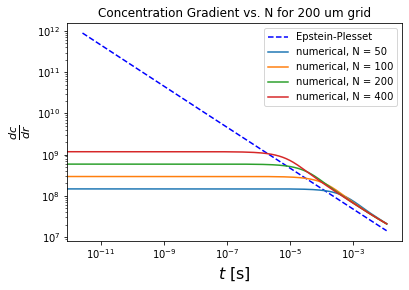

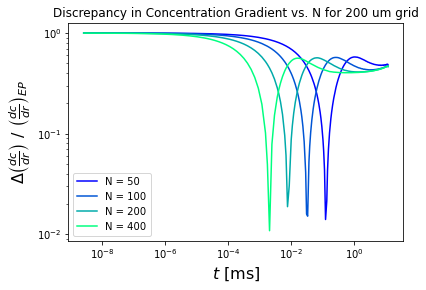

In [10]:
# plots results
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.asarray(t_eps) - t_eps[0], dcdr_eps, 'b--', label='Epstein-Plesset')

for N, dcdr_num, t_num in zip(N_list, dcdr_num_list, t_num_list):
    ax.plot(np.asarray(t_num) - t_num[0], dcdr_num, label='numerical, N = {0:d}'.format(N))


ax.set_xlabel(r'$t$ [s]', fontsize=16)
ax.set_ylabel(r'$\frac{dc}{dr}$', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')

plt.legend()
ax.set_title('Concentration Gradient vs. N for 200 um grid')

# plot difference
dcdr_diff_list = []
label_list = []
reload(pltd)
for N, dcdr_num, t_num in zip(N_list, dcdr_num_list, t_num_list):
    # computes fractional differencies in concentration gradient
    dcdr_diff_list += [np.abs(np.interp(t_eps, t_num, dcdr_num) - np.asarray(dcdr_eps)) / np.asarray(dcdr_eps)]
    label_list += ['N = {0:d}'.format(N)]
    
# plots discrepancies
ax = pltd.diff(t_eps, dcdr_diff_list, label_list)
ax.set_title('Discrepancy in Concentration Gradient vs. N for 200 um grid')

Clearly, the error was not reduced by increasing the domain size, so it is not a "finite-size" effect.

### Differences in Time for Numerical Model

I noticed that the numerical model's `t_flow` list of times ended at an earlier time than either the analytical model's timeline or the numerical model's bubble's timeline `t_bub`. 

**February 21, 2021**: found bug in `bubble.adaptive_time_step()` where the method took the result from taking two time steps but passed back the length of one time step for use in the diffusion problem, resulting in mismatched conditions between bubble and bulk.

In [20]:
reload(bubble)
reload(bubbleflow)

# sets domain size back to 100 um
R_max = 100E-6 # [m]

# simulation parameters
N = 400
dt = 1E-12 # [s]
D_max = 3E-8 # [m^2/s]
dt_max = 0.5*(R_max/N)**2/D_max
R_max = 100E-6

# performs simulation
t_flow, c, t_num, m, D, p, p_bub, if_tension, \
c_bub, c_bulk, R, rho_co2, v, r_arr_data = bubbleflow.num_fix_D(t_nuc, eps_params, R_max, N, dt_max=dt_max)

In [21]:
print('Numerical model for flow ends at {0:.6f} s.'.format(t_flow[-1]))
print('Numerical model for the bubble ends at {0:.6f} s.'.format(t_num[-1]))
print('Epstein-Plesset model ends at {0:.6f} s.'.format(t_eps[-1]))
print('The bubble will reach the end of the channel after {0:.6f} s.'.format(L/v))

Numerical model for flow ends at 0.291048 s.
Numerical model for the bubble ends at 0.291048 s.
Epstein-Plesset model ends at 0.291059 s.
The bubble will reach the end of the channel after 0.291047 s.


*Previously*: For some reason, the Epstein-Plesset model finishes at a later time than the numerical model.

*Now*: they match within one time step!